In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as optimize

In [2]:
import numpy as np

def nll(theta,t):
    f,tau1,tau2 = theta
    return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  

class tcdecay_distribution:
    
    # constructors
    def __init__(self, f, tau1, tau2):
        self.f = float(f)
        self.tau1 = float(tau1)
        self.tau2 = float(tau2)
        
    # method to return exponential distribution    
    def evaluate_md(self,t):
        return self.f*(1/self.tau1)*np.exp(-t/self.tau1)+(1-self.f)*(1/self.tau2)*np.exp(-t/self.tau2)
    
    # method to return maximum value of distribution  
    def maximum(self):
        return 10.0
    
    # method to return random number with distribution
    # choose numpy random exponential or custom code 'calum'    
    def random_val(self):           
        x1 = 0.
        x2 = 0.
        x3 = 1.
        while ( x3 > x2 ):
            x1 = np.random.uniform()
            x1 = x1*7.
            x2 = self.evaluate_md(x1)
            x3 = np.random.uniform() * self.maximum()
        
        return x1
    
    # integrates area under the curve, in this example should be normalised
    # therefore always roughly equal to 1
    def numeric_integral(self,lo,hi,npoints=100000):
        
        sumf = 0
        
        for i in range(0,npoints):
            x = lo+np.random.uniform()*(hi-lo)
            sumf += self.evaluate_md(x)
            
        return sumf*(hi-lo)/npoints
    
    def nll(self,theta,t):
        f,tau1,tau2 = theta
        return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  
    
    # performs an observation by taking n_muons random values
    # of the distribution
    def observation(self,n_tests=10000,method='TNC'):
        results = []
        for i in range(0,n_tests):
            results.append(self.random_val())
        
        mle_estimates = optimize.minimize(self.nll, [self.f, self.tau1, self.tau2], args=(np.array(results)),method=method)
        params = mle_estimates['x']
        # return (parameters_estimates, results)
        return params, np.array(results)

In [18]:
true_params = [0.74849409,  0.1978367 ,  1.30720393]

In [3]:
test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)

In [4]:
test.numeric_integral(0,10)

0.99836607431997759

In [5]:
val, result = test.observation()  
val,result.shape

(array([ 0.72325671,  0.19008336,  1.19257345]), (10000,))

In [26]:
np.max(result)

6.9992773610430943

In [6]:
val, result = test.observation(method='Nelder-mead')  
val,result.shape

(array([ 0.7381317 ,  0.19707541,  1.27325337]), (10000,))

In [7]:
data = np.loadtxt('DecayTimesData.txt')
data.shape

(10000,)

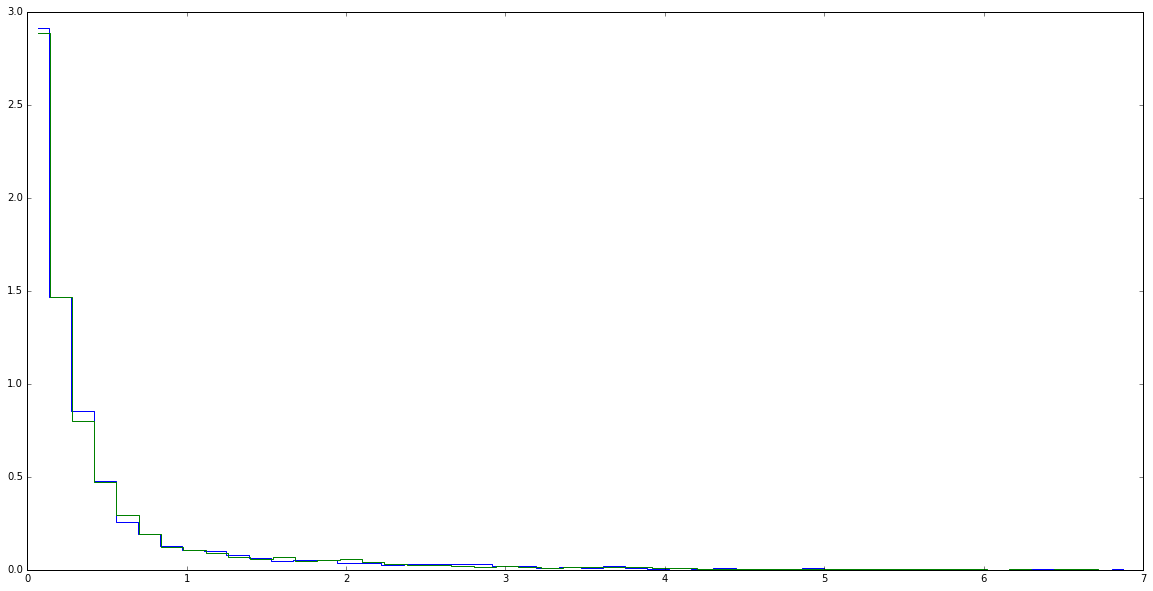

In [8]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

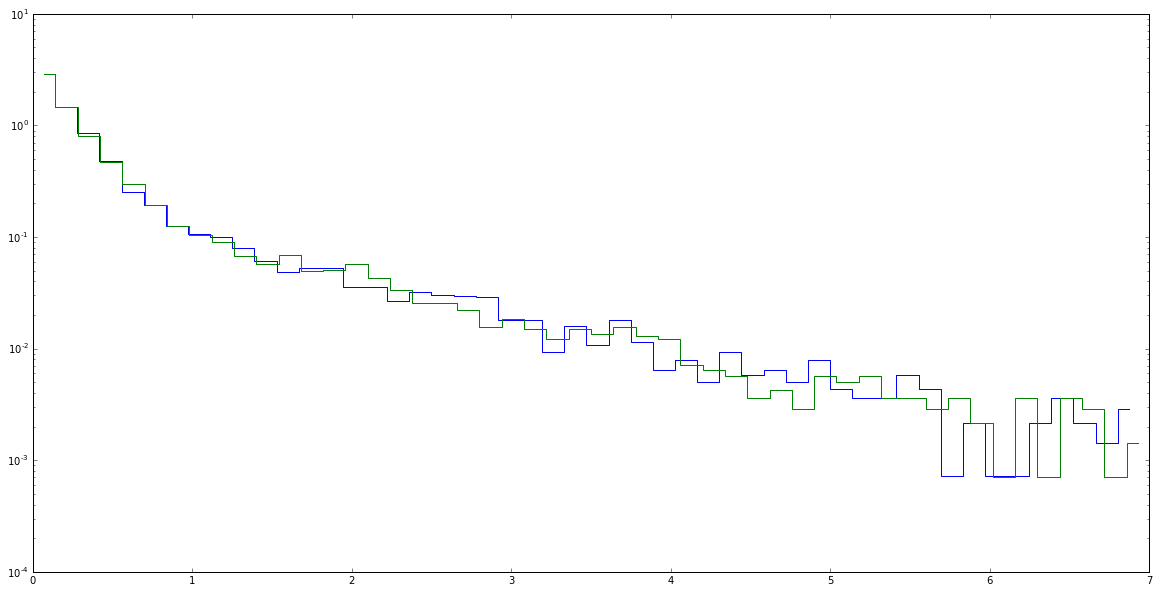

In [9]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

plt.yscale('log')

test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)
results = []
for _ in range(50):
    results.append(test.observation(method='Nelder-mead')[0])

In [71]:
results_tnc = np.load('/home/calum/Documents/NumRep/max_likelihood/run_sim_tnc.npy')
lresults_tnc = np.load('/home/calum/Documents/NumRep/max_likelihood/large_run_sim_tnc.npy')
results_nm = np.load('/home/calum/Documents/NumRep/max_likelihood/run_sim_nm.npy')
lresults_nm = np.load('/home/calum/Documents/NumRep/max_likelihood/large_run_sim_nm.npy')

In [72]:
np.array(results_tnc).shape, np.array(results_nm).shape

((5000, 3), (5000, 3))

In [126]:
print(np.median([row[0] for row in lresults_tnc]), np.median([row[1] for row in lresults_tnc]), np.median([row[2] for row in lresults_tnc]))
print(np.std([row[0] for row in lresults_tnc if 4 >row[0] > 0]), np.std([row[1] for row in lresults_tnc if 2 >row[0] > 0]), np.std([row[2] for row in lresults_tnc if 2 >row[0] > 0]))

0.741966801771 0.195730560796 1.24876472089
0.0283231603919 0.00375126489398 0.0343162362763


(0.009393153471043237,
 0.0093161422232427536,
 0.74143871886945012,
 0.74059827615052221,
 0.74849409)

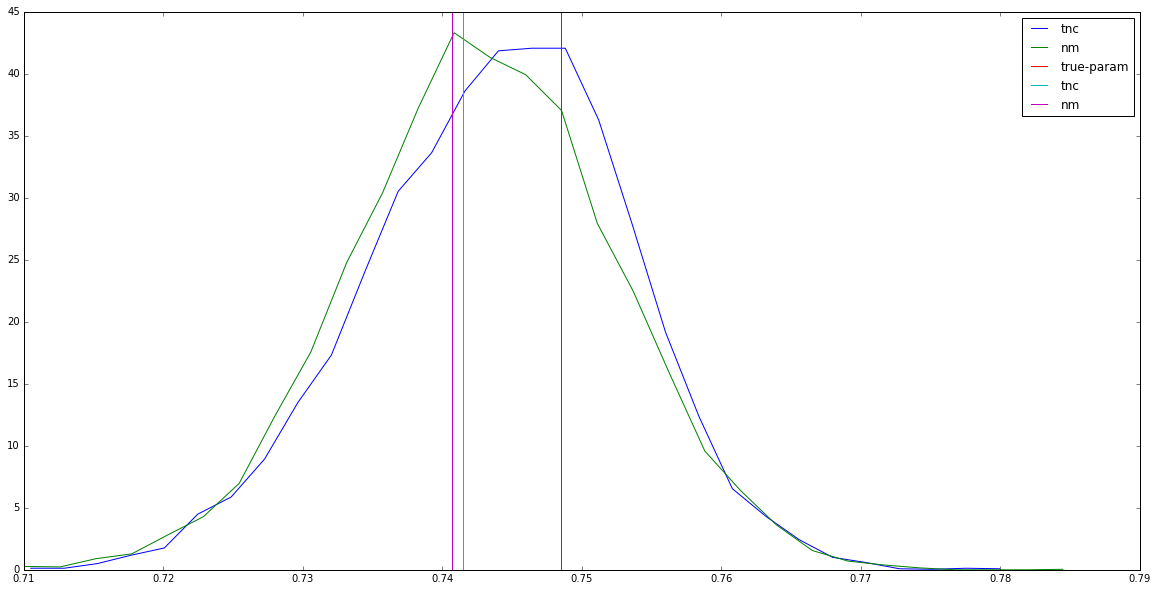

In [129]:
plt.figure(figsize=(20,10))
n, bins = np.histogram(np.array([row[0] for row in lresults_tnc if 1 >row[0] > 0]), bins=30, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]+step,n,label='tnc')

n, bins = np.histogram(np.array([row[0] for row in lresults_nm if 1 >row[0] > 0]), bins=30, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]+step,n,label='nm')

plt.plot([true_params[0],true_params[0]],[0,45],label='true-param')
tnc = [row[0] for row in results_tnc if 1 >row[0] > 0]
plt.plot([np.mean(tnc),np.mean(tnc)],[0,45],label='tnc')
nm = [row[0] for row in results_nm if 1 >row[0] > 0]
plt.plot([np.median(nm),np.median(nm)],[0,45],label='nm')
plt.legend()
np.std(tnc), np.std(nm), np.mean(tnc), np.mean(nm), true_params[0]

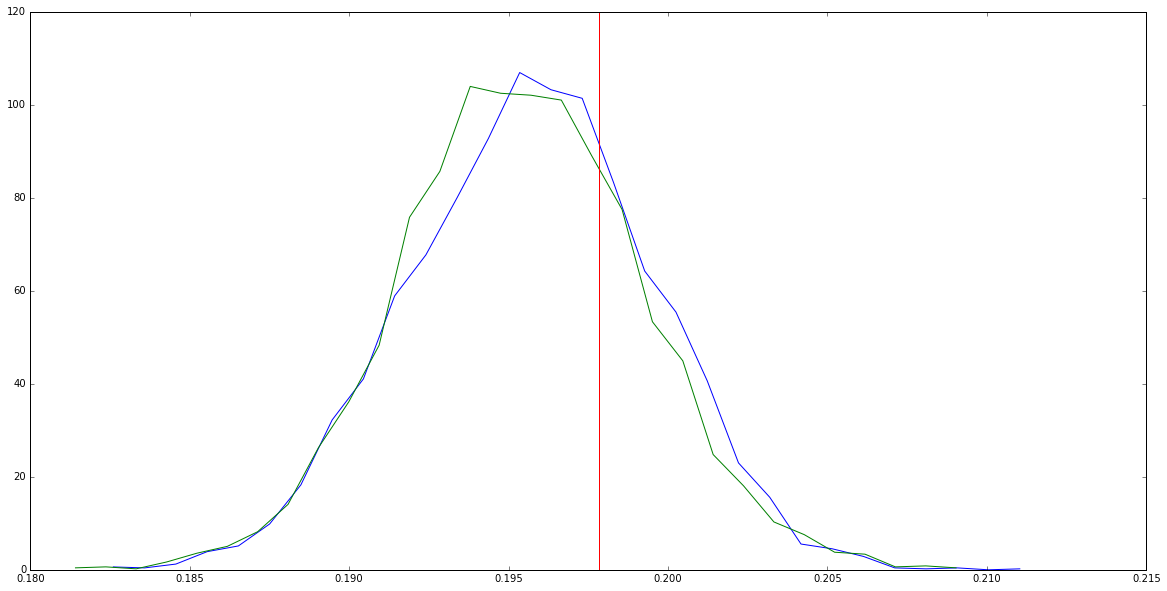

In [23]:
n, bins = np.histogram(np.array([row[1] for row in results_tnc if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)

n, bins = np.histogram(np.array([row[1] for row in results_nm if 10 >row[0] > 0]), bins=30, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)
plt.plot([true_params[1],true_params[1]],[0,120])

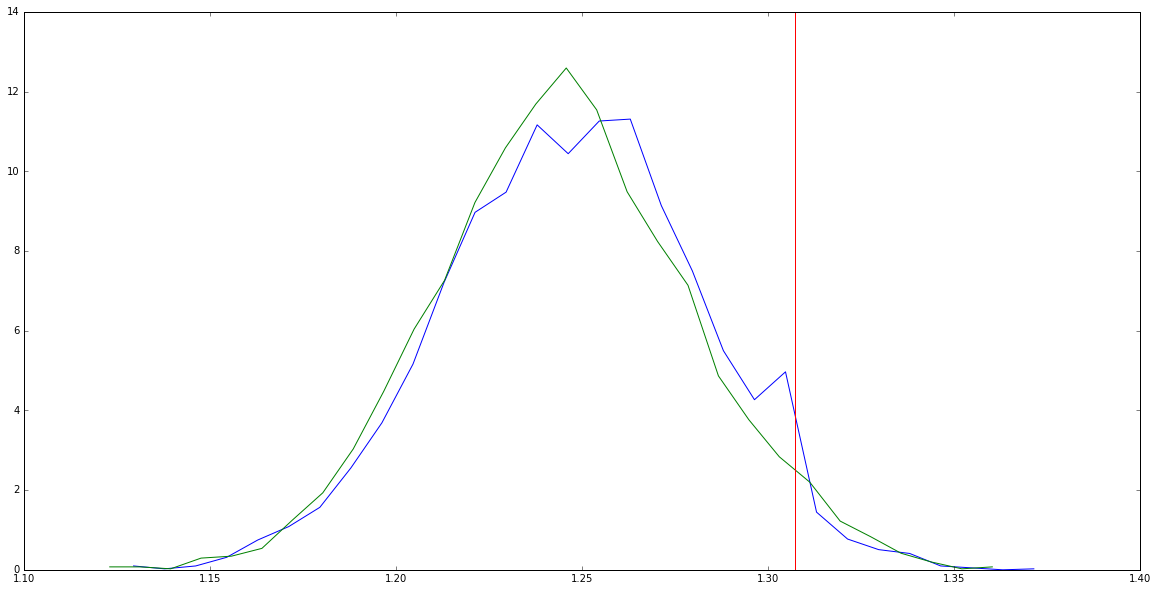

In [25]:
n, bins = np.histogram(np.array([row[2] for row in results_tnc if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)

n, bins = np.histogram(np.array([row[2] for row in results_nm if 10 >row[0] > 0]), bins=30, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)
plt.plot([true_params[2],true_params[2]],[0,14])

In [93]:
run100 = np.load('/home/calum/Documents/NumRep/max_likelihood/run100.npy')
run500 = np.load('/home/calum/Documents/NumRep/max_likelihood/run500.npy')
run1000 = np.load('/home/calum/Documents/NumRep/max_likelihood/run1000.npy')
run2000 = np.load('/home/calum/Documents/NumRep/max_likelihood/run2000.npy')
run10000 = np.load('/home/calum/Documents/NumRep/max_likelihood/large_run_sim_tnc.npy')

In [113]:
def plot_run(array,idx):
    n, bins = np.histogram(np.array([row[idx] for row in array if .95 >row[0] > .55]), bins=20, normed=True)

    step = (bins[1]-bins[0])/2
    plt.plot(bins[1:]-step,n)
    print(np.mean([row[idx] for row in array if 1 >row[0] > 0]))

0.740986669063
0.740275264759
0.741152820942
0.741258805381
0.741548660485


(0.4, 1.0)

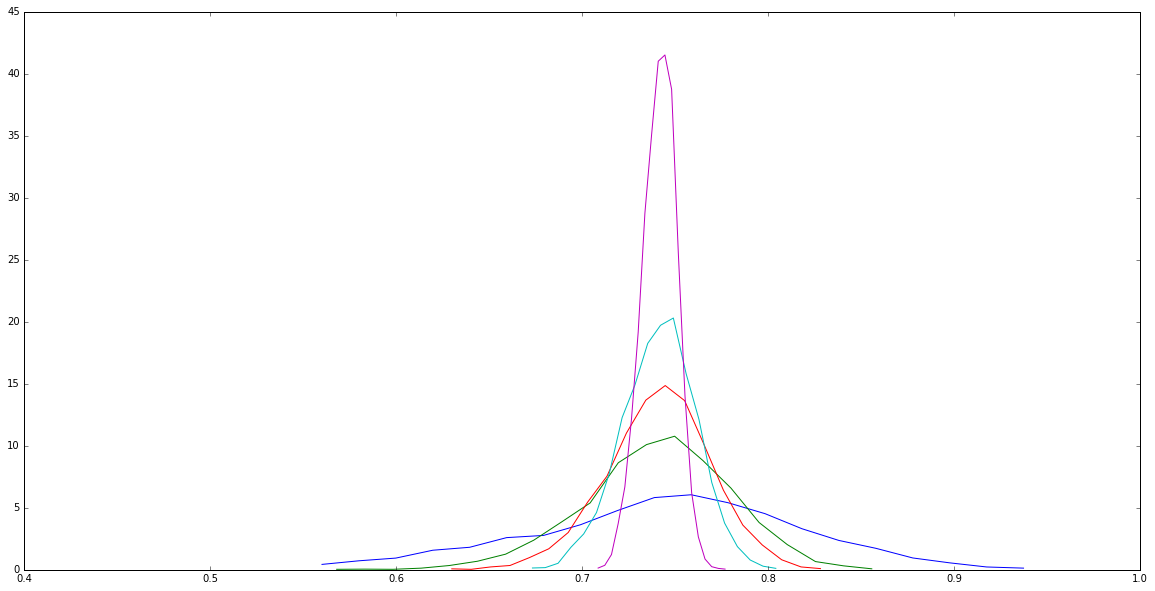

In [114]:
plt.figure(figsize=(20,10))
plot_run(run100,0)
plot_run(run500,0)
plot_run(run1000,0)
plot_run(run2000,0)
plot_run(run10000,0)
plt.xlim(0.4,1.0)

0.197869564389
0.195638590726
0.195742024266
0.195687831317
0.195712557901


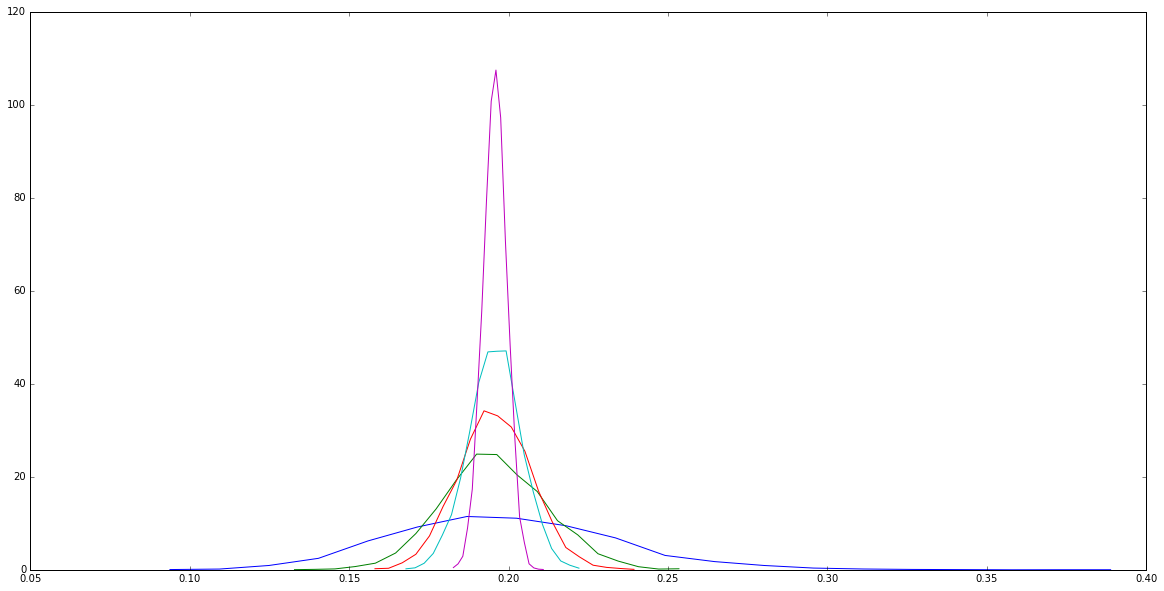

In [115]:
plt.figure(figsize=(20,10))
plot_run(run100,1)
plot_run(run500,1)
plot_run(run1000,1)
plot_run(run2000,1)
plot_run(run10000,1)

1.28541448941
1.25771917682
1.25306437235
1.25016271636
1.24876936876


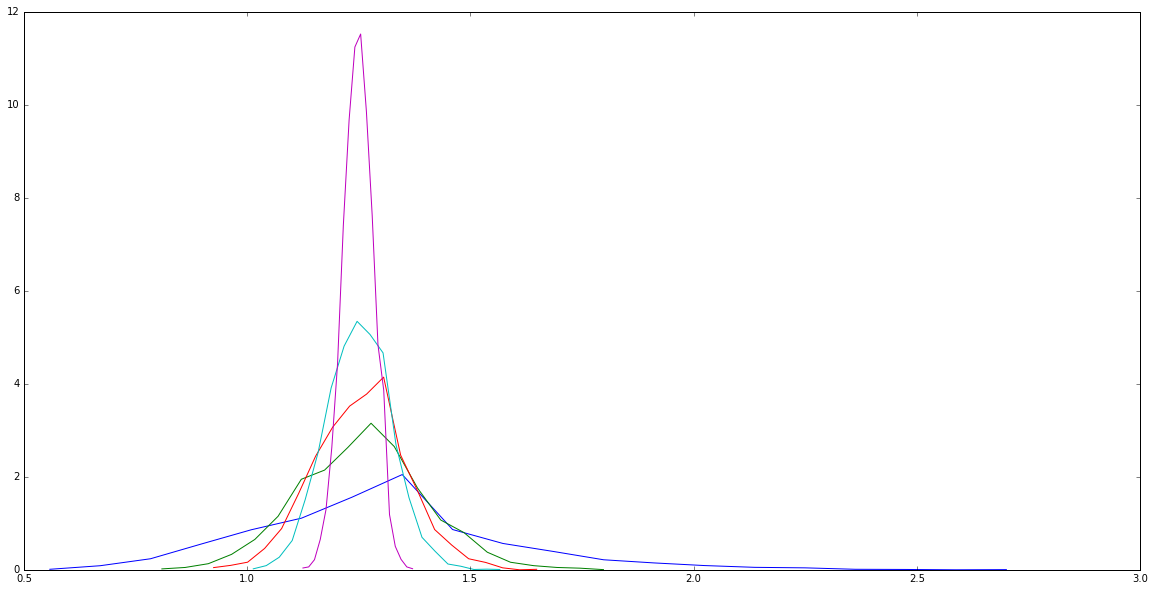

In [116]:
plt.figure(figsize=(20,10))
plot_run(run100,2)
plot_run(run500,2)
plot_run(run1000,2)
plot_run(run2000,2)
plot_run(run10000,2)

In [105]:
tom = np.load('/home/calum/Documents/NumRep/max_likelihood/5run1000.npy')

1.24478155444


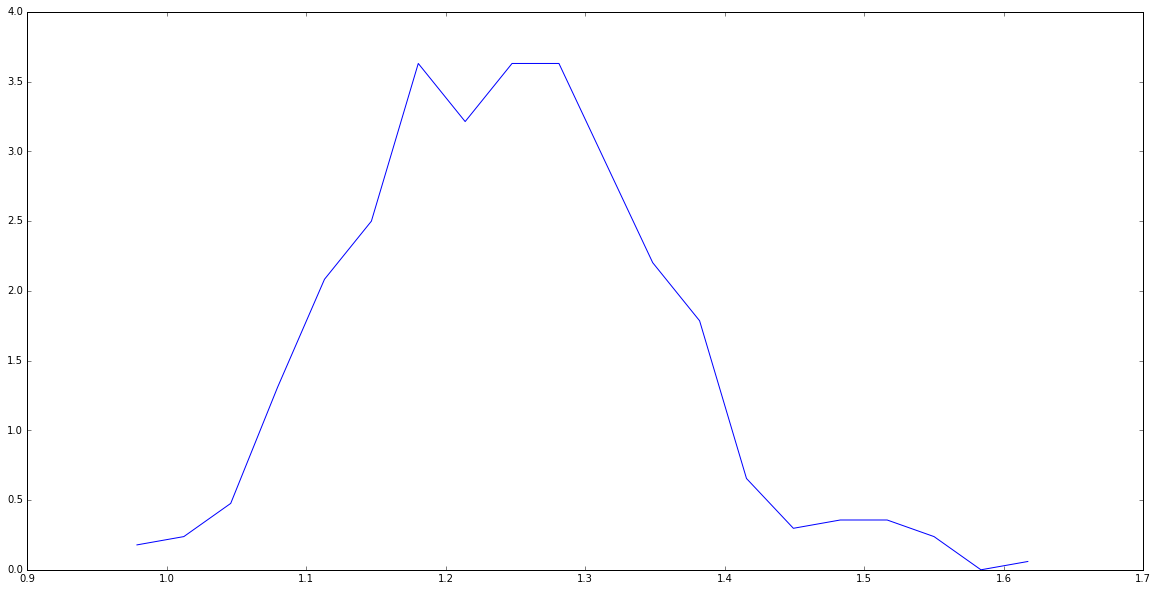

In [106]:
plt.figure(figsize=(20,10))
plot_run(tom,2)